# Solutions

1. For a given cavity, find its resonance frequency.
2.  Assuming the Nano-VNA is calibrated (2-port calibration) with center of resonance frequency and required span, capture live data from Nano-VNA.
3. Calculate the 3dB bandwidth, Quality factors ($Q_{0}$ and $Q_{L}$), and coupling factor.

## Analysis

In [1]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import skrf as rf
from math import pi
from scipy.optimize import least_squares
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['font.size'] = 10
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
from nanovna import NanoVNA

In [2]:
class CavityAnalysis:
    def __init__(self, s11_cor=0, co_fname=None):
        nv = NanoVNA()
        # make sure the calibrated stop and start frequencies are same for capturing data, 2 MHz span
        start_f, stop_f = 499.2e6, 500.2e6
        nv.set_sweep(start_f, stop_f)
        f = nv.fetch_frequencies()
        self.freq_data = (np.array(f))/1e6  # frequency in MHz
        self.s21 = nv.data(1)
        self.s11 = nv.data(0)
        # correct for rotation in S11, after curve fit, initially it is zero
        self.s11 = self.s11*np.exp(1j*(-s11_cor))
        self.s21_data = 20 * np.log10(np.abs(self.s21))  # magnitude in dB
        self.s21_deg = np.angle(self.s21)  # phase in radians
        self.s11_data = np.abs(self.s11)   # magnitude
        self.s11_deg = np.angle(self.s11)  # phase in radians
        # Results
        self.fs  = 0.0
        self.df  = 0.0
        self.Q_L = 0.0
        self.Q_0 = 0.0
        self.beta = 0.0
        self.Cm  = 0.0
        self.Lm  = 0.0
        # Smith plot here, can clearly see under/critical/over coupling case
        self.s11_ant(nv)
        self.__call__()

    def beta_cal(self):
        s11_min = np.min(self.s11_data)
        ix = np.where(self.s11_data == s11_min)[0][0]
        if self.s11[ix].real < 0:
            s11_min = -s11_min
            print("############ Over-coupled #############")
        else:
            print("############ Under-coupled #############")
        self.beta = (1 - s11_min) / (1 + s11_min)

    def s11_ant(self, nv):
        self.beta_cal()
        fig, ax = plt.subplots()
        n = nv.skrf_network(self.s11)
        n.plot_s_smith()
        plt.title("Smith Chart")
        # text = "beta:{:.5f}".format(self.beta)
        # ax.text(self.beta, 0, text, va='top')

    def Rs_calc(self, s21, R_L):
        """ ESR calculation """
        Rs = 2 * R_L * (pow(10, (-s21 / 20)) - 1)
        Reff = 2 * R_L + Rs
        return Rs, Reff

    def df_calc(self, fl, fh):
        """ bandwidth calculation """
        return fh - fl

    def Cm_Lm_calc(self, fs, df, Rs, Reff):
        """ Calculate motional capacitance and inductance """
        Cm = df / (2.0 * pi * (pow(fs, 2)) * Reff)
        Lm = Reff / (2.0 * pi * df)
        Q_L = fs / df
        Q_0 = (1 + self.beta) * Q_L
        return Cm, Lm, Q_0, Q_L

    def find_max_freq_mag(self, data):
        """ find the maximum S21 magnitude and its corresponding frequency """
        max_idx = np.where(data == np.amax(data))
        mag = np.max(data)
        freq = self.freq_data[max_idx][0]
        return (freq, mag)

    def find_nearest(self, array, value):
        """ find the value closest to the given data """
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    def annot(self, ax, freq, mag, y, offset=0.1):
        """ used for annotating max, -3 dB points on S21 plot   """
        text = "{:.3f} dBm\n{:.5f} MHz".format(mag, freq)
        plt.axvline(x=freq, color='b', label='axvline - full height')
        ax.text(freq+offset, y, text, rotation=0, va='top')

    def ann_stats(self, ax, xloc, yloc):
        """ used for annotating crystal parameters on the S21 plot """
        txt  = "Cm: {:8.3f} pF\n".format(self.Cm/1e-15)
        txt += "Rs:  {:8.3f} Ohm\n".format(self.Rs)
        txt += "Lm: {:8.3f} mH\n".format(self.Lm/1e-3)
        txt += "bw: {:8.3f} kHz\n".format(self.df/1e3)
        txt += "Q_0:  {:8.3f}\n".format(self.Q_0)
        txt += "Q_L:  {:8.3f}\n".format(self.Q_L)
        txt += "Beta:  {:.5f}".format(self.beta)
        ax.text(xloc, yloc, txt, va='top')

    def find_3dB_points(self):
        """ find the -3 dB points """
        fs, mag   = self.find_max_freq_mag(self.s21_data)
        center_idx = np.where(self.s21_data == mag)[0][0]

        left_mag = self.find_nearest(self.s21_data[:center_idx], mag-3)
        left_idx = np.where(self.s21_data == left_mag)[0][0]
        left_freq = self.freq_data[left_idx]

        right_mag = self.find_nearest(self.s21_data[center_idx:], mag-3)
        right_idx = np.where(self.s21_data == right_mag)[0][0]
        right_freq = self.freq_data[right_idx]
        return ((left_freq, left_mag), (right_freq, right_mag))

    def plot_3db(self, fname):
        """ S21 magnitude plot """
        fig, ax = plt.subplots()
        plt.plot(self.freq_data, self.s21_data, "-b")
        self.annot(ax, self.freq_0deg, self.S21_0deg, np.max(self.s21_data), offset=0.00007)
        # self.annot(ax, self.freq_460MHz, self.S21_460MHz, np.max(self.s21_data)+0.7)
        idx = np.where(self.s21_data == self.left[1])
        self.annot(ax, self.left[0], self.left[1], self.s21_data[idx][0], offset=-0.0002)
        idx = np.where(self.s21_data == self.right[1])
        self.annot(ax, self.right[0], self.right[1], self.s21_data[idx][0], offset=0.00005)
        plt.title("S21")
        self.ann_stats(ax, plt.xlim()[0]+0.00002, plt.ylim()[1]-0.1)
        plt.grid(True)
        plt.xlabel("Frequency [MHz]")
        plt.ylabel("Magnitude [dBm]")
        # plt.show()
        plt.savefig(fname)

    def __call__(self):
        self.freq_0deg, self.S21_0deg = self.find_max_freq_mag(self.s21_data)
        self.fs = self.freq_0deg

        self.left, self.right = self.find_3dB_points()
        self.Rs, self.Reff = self.Rs_calc(self.S21_0deg, 50)
        self.df = self.df_calc(self.left[0]*1e6, self.right[0]*1e6)
        self.Cm, self.Lm, self.Q_0, self.Q_L = self.Cm_Lm_calc(
            self.freq_0deg * 1e6, self.df, self.Rs, self.Reff)
        print("Resonance Freq: %3.4f MHz at %3.4f dBm" % (self.freq_0deg, self.S21_0deg))
        print("Full bandwidth: %3.4f kHz" % (self.df/1e3))
        print("Q_L: %3.4f" % self.Q_L)
        print("Q_0: %3.4f" % self.Q_0)
        print("Coupling factor (beta): %.4f" % self.beta)

firmware version: 1.1.1
############ Over-coupled #############
Resonance Freq: 499.7000 MHz at -10.3514 dBm
Full bandwidth: 150.0000 kHz
Q_L: 3331.3333
Q_0: 7102.5316
Coupling factor (beta): 1.1320


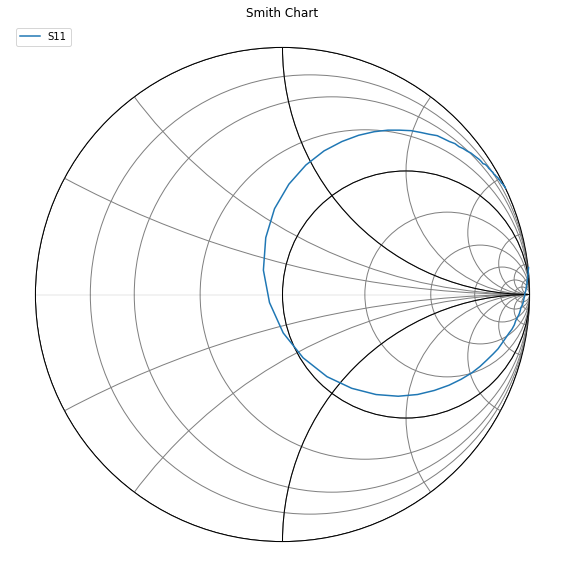

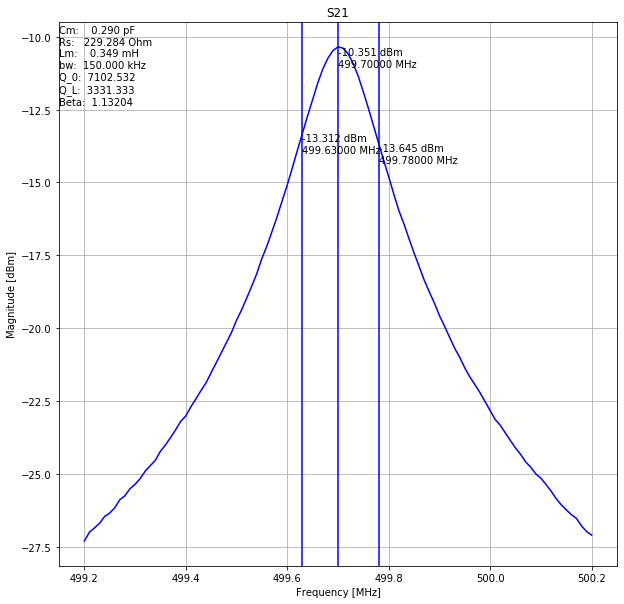

In [3]:
c = CavityAnalysis()
c.plot_3db("Res_bw.png")
guess = (c.fs, c.Q_L)

## S21 curve-fit

Initial guess values =  (499.7, 3331.3333333333335)
Final guess values =  [ 499.70213333 3331.33333357]
Least Squares status = 3, iterations= 20, cost = 0
Beta values =  [ 8.81506763e-05  1.36125320e-03 -2.80959028e-01 -1.06545924e-01]
Root Mean Square Error :0.002944
RMSE Normalised        :0.025490


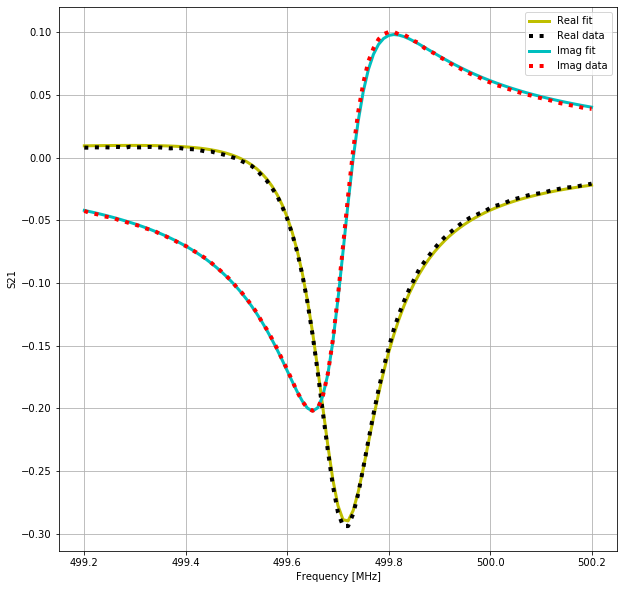

In [4]:
#  The complex transmission coefficient, S21 as a function of driving frequency f.
# \begin{align}S_{21}(f) = \frac{S_{21max}}{1+2j \cdot Q \cdot (\frac {f}{f_0} -1)}\end{align}
def lorentzian_complx(f, f0, Q):
    return 1 / (1 + 2*1j * Q * ((f/f0) - 1))

# Simple linear regression model with Coupling and Rotation
# \begin{align} y_i =\beta_0 + \beta_1 +\beta_2 \cdot a + \beta_3 \cdot a  + \epsilon_i\end{align}
# $y_i$ = S21 of the cavity in complex form or [real, img] form array and $a$ = Lorentzian function
def basis_cpx(params, f):
    f0, Q = params
    constant = np.array(len(f)*[1+0j])
    lorentz = lorentzian_complx(f, f0, Q)
    basis = np.vstack((constant, constant*1j, lorentz, lorentz*1j))
    return basis

def residuals(params, f, s21_data, ret='beta'):
    y = np.concatenate((s21_data.real, s21_data.imag))
    basis = basis_cpx(params, f)
    a = np.vstack([np.concatenate((b.real, b.imag)) for b in basis]).T
    beta, res, rank, singulars = np.linalg.lstsq(a, y, rcond=None)
    if (ret == 'beta'):
        return beta
    elif (ret == 'residuals'):
        return res
    return None

f, y = c.freq_data, c.s21
fit_nls = least_squares(residuals, guess, args=(f, y, 'residuals'))
fit = lorentzian_complx(f, *fit_nls.x)
final_f  = fit_nls.x[0]
final_QL = fit_nls.x[1]
print("Initial guess values = ", guess)
print("Final guess values = ", fit_nls.x)
print("Least Squares status = %d, iterations= %d, cost = %d" % (fit_nls.status, fit_nls.nfev, fit_nls.cost))

fit_beta = residuals(guess, f, y, ret='beta')
print("Beta values = ", fit_beta)
fit_f = np.sum(np.vstack(fit_beta[:]) * basis_cpx(fit_nls.x, f), axis=0)

mse = np.square(abs(np.subtract(y, fit_f))).mean()
rmse = np.sqrt(mse)
print("Root Mean Square Error :%4f" % rmse)
print("RMSE Normalised        :%4f" % (rmse/abs(y).mean()))

# plot both the real and fitted data
plt.figure()
fnom = 499.71e6
fp = f
plt.plot(fp, fit_f.real, label='Real fit', color='y', linewidth=3)
plt.plot(fp, y.real, label='Real data', linestyle='dotted', color='k', linewidth=4)
plt.plot(fp, fit_f.imag, label='Imag fit', color='c', linewidth=3)
plt.plot(fp, y.imag, label='Imag data', linestyle='dotted', color='r', linewidth=4)
plt.grid(True)
plt.legend(loc='best')
plt.xlabel("Frequency [MHz]")
plt.ylabel("S21")
plt.savefig("iq.png")
# plt.show()

mag = np.sqrt(fit_f.real**2 + fit_f.imag**2)
phs = np.arctan(fit_f.imag/fit_f.real)
mag_log = 20*np.log10(mag)

## S11 curve-fit

Initial guess values =  (499.70213333366485, 3331.3333335664665)
Final guess values =  [ 499.71116863 3331.33333306]
Least Squares status = 3, iterations= 19, cost = 0
Beta values =  [ 0.96190755  0.28849103 -1.01836762 -0.39786339]
Root Mean Square Error :0.045748
RMSE Normalised        :0.052702


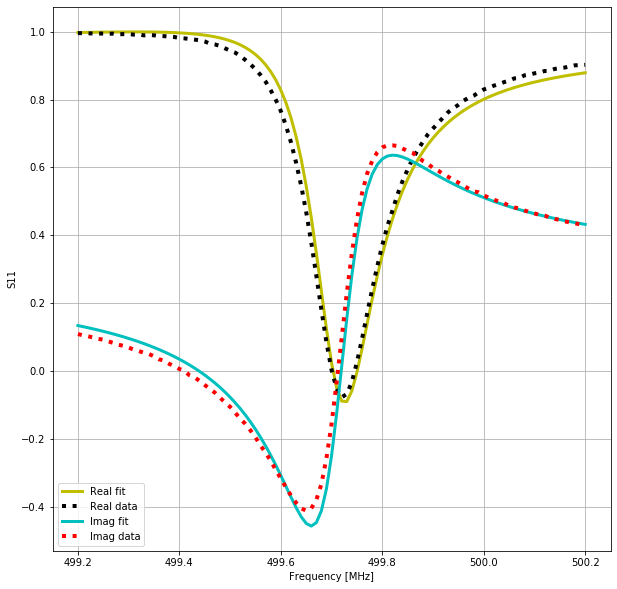

In [5]:
# From the polar plot, we can see cirlce rotated so we need to curve-fit it.
# since we know fs an BW and Q_L from S21 curve fit, let's find the beta and Q_0 from S11
def lorentzian_complx(f, f0, Q):
    return 1 / (1 + 2*1j * Q * ((f/f0) - 1))

# Simple linear regression model with Coupling and Rotation
def basis_cpx(params, f):
    f0, Q = params
    constant = np.array(len(f)*[1+0j])
    lorentz = lorentzian_complx(f, f0, Q)
    basis = np.vstack((constant, constant*1j, lorentz, lorentz*1j))
    return basis

def residuals(params, f, s11_data, ret='beta'):
    y = np.concatenate((s11_data.real, s11_data.imag))
    basis = basis_cpx(params, f)
    a = np.vstack([np.concatenate((b.real, b.imag)) for b in basis]).T
    beta, res, rank, singulars = np.linalg.lstsq(a, y, rcond=None)
    if (ret == 'beta'):
        return beta
    elif (ret == 'residuals'):
        return res
    return None

f, y = c.freq_data, c.s11
guess_s11 = (final_f, final_QL)
fit_nls = least_squares(residuals, guess_s11, args=(f, y, 'residuals'))
fit = lorentzian_complx(f, *fit_nls.x)
print("Initial guess values = ", guess_s11)
print("Final guess values = ", fit_nls.x)
print("Least Squares status = %d, iterations= %d, cost = %d" % (fit_nls.status, fit_nls.nfev, fit_nls.cost))

fit_beta = residuals(guess, f, y, ret='beta')
print("Beta values = ", fit_beta)
fit_f = np.sum(np.vstack(fit_beta[:]) * basis_cpx(fit_nls.x, f), axis=0)

mse = np.square(abs(np.subtract(y, fit_f))).mean()
rmse = np.sqrt(mse)
print("Root Mean Square Error :%4f" % rmse)
print("RMSE Normalised        :%4f" % (rmse/abs(y).mean()))

# plot both the real and fitted data
plt.figure()
fnom = 499.71e6
fp = f
plt.plot(fp, fit_f.real, label='Real fit', color='y', linewidth=3)
plt.plot(fp, y.real, label='Real data', linestyle='dotted', color='k', linewidth=4)
plt.plot(fp, fit_f.imag, label='Imag fit', color='c', linewidth=3)
plt.plot(fp, y.imag, label='Imag data', linestyle='dotted', color='r', linewidth=4)
plt.grid(True)
plt.legend(loc='best')
plt.xlabel("Frequency [MHz]")
plt.ylabel("S11")
plt.savefig("iq_s11.png")
# plt.show()

mag = np.abs(fit_f)
phs = np.arctan(fit_f.imag/fit_f.real)
mag_log = 20*np.log10(mag)

Correction angle for S11: 0.29138 radians
firmware version: 1.1.1
############ Over-coupled #############
Resonance Freq: 499.7000 MHz at -10.3378 dBm
Full bandwidth: 150.0000 kHz
Q_L: 3331.3333
Q_0: 7102.9255
Coupling factor (beta): 1.1322


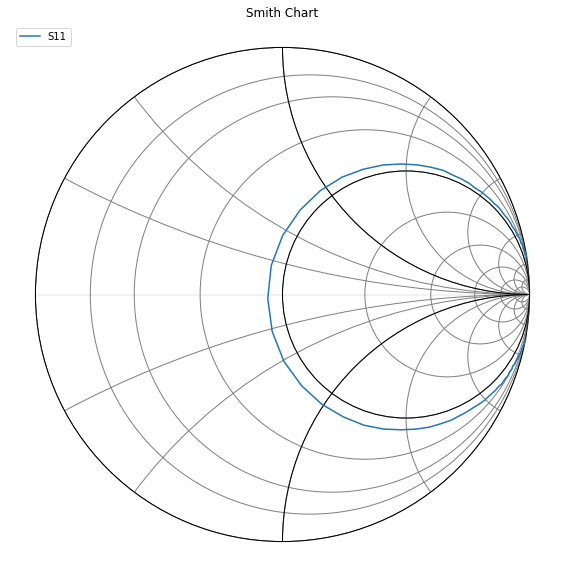

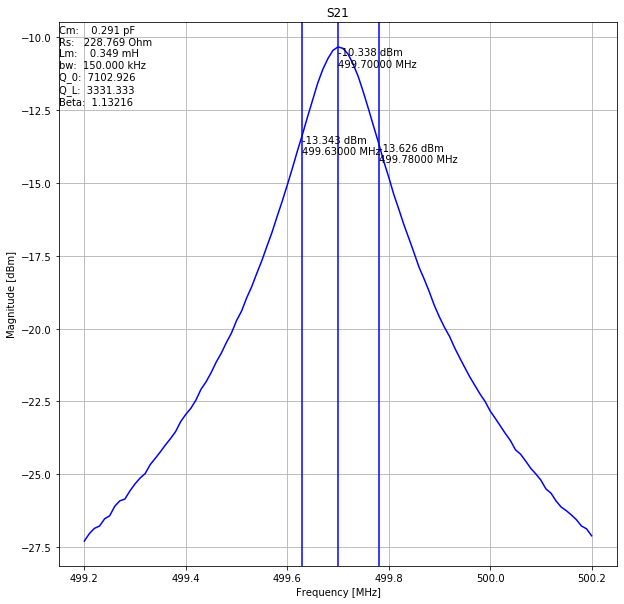

In [6]:
# correct for rotation by passing the value
s11_correction = np.arctan(fit_beta[1]/fit_beta[0])
print("Correction angle for S11: %1.5f radians" % s11_correction)
c = CavityAnalysis(s11_correction)
c.plot_3db("Res_bw.png")

## Expected RF cavity measurement results


| Cavity | fs (MHz) | Beta |  Q_0 |  Q_l | max(S_21) (dB)    |
|:------:|----------|:----:|:----:|:----:|:-----------------:|
|      1 | 499.66   | 0.86 | 7777 | 4163 |              -9.0 |
|      2 | 499.53   | 0.29 | 4622 | 3568 |              -4.7 |
|      3 | 499.66   | 0.58 | 6605 | 4163 |              -8.3 |
|      4 | 499.70   | 1.13 | 7102 | 3331 |             -10.3 |
|      5 | 499.67   | 3.44 | 5697 | 1281 |              -9.3 |
|      6 | 499.70   | 1.73 | 5953 | 2172 |              -6.0 |
